In [1]:
from sklearn.model_selection import train_test_split
from transformers import AutoTokenizer, TFAutoModel
from tensorflow import keras
from tensorflow.keras import layers, losses, optimizers, metrics, regularizers
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import tensorflow as tf
import sys

/home/yu/kaggle-tweet-sentiment/.venv/lib64/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-02-02 12:05:11.850438: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1738515911.861731  155425 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1738515911.865139  155425 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-02-02 12:05:11.877126: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performan

In [2]:
train = pd.read_csv("data/train.csv").dropna()
train, test = train_test_split(train, test_size=0.15)
print(train.info())
print(test.info())
# TODO see if selected_text needs to be fixed to word boundaries

<class 'pandas.core.frame.DataFrame'>
Index: 23358 entries, 21010 to 12237
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   textID         23358 non-null  object
 1   text           23358 non-null  object
 2   selected_text  23358 non-null  object
 3   sentiment      23358 non-null  object
dtypes: object(4)
memory usage: 912.4+ KB
None
<class 'pandas.core.frame.DataFrame'>
Index: 4122 entries, 18030 to 4584
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   textID         4122 non-null   object
 1   text           4122 non-null   object
 2   selected_text  4122 non-null   object
 3   sentiment      4122 non-null   object
dtypes: object(4)
memory usage: 161.0+ KB
None


In [3]:
max_text_len = 128
span_indices_size = max_text_len * (max_text_len + 1) // 2
span_indices = np.zeros((max_text_len, max_text_len), dtype=int)
span_indices[np.triu_indices(max_text_len, m=max_text_len)] = np.arange(span_indices_size)
span_indices = np.flip(span_indices, axis=1)
inference_batch_size = 1000

def tokenize(texts, padding=True):
    padding = "max_length" if padding else "longest"
    return tokenizer(texts, padding=padding, max_length=max_text_len, return_tensors="tf")

def detokenize(ids, skip_special=True):
    return tokenizer.batch_decode(ids, skip_special_tokens=skip_special)

# https://stackoverflow.com/a/7100681
def rolling_window(a, size):
    shape = a.shape[:-1] + (a.shape[-1] - size + 1, size)
    strides = a.strides + (a. strides[-1],)
    return np.lib.stride_tricks.as_strided(a, shape=shape, strides=strides)

def find_span(texts, spans, word_boundary=False):
    texts = np.array(texts)
    spans = np.array(spans)[:, 1:]
    sizes = spans.argmin(axis=1) - 1
    span_class = np.zeros((texts.shape[0], 1))
    for i, text in enumerate(texts):
        skips = 0
        window_size = sizes[i]
        if word_boundary:
            allowed = set(texts[i])
            if spans[i, 0] not in allowed and window_size > 1:
                skips = 1
            if spans[i, -1] not in allowed and window_size - skips > 1:
                window_size -= 1
        matched_window = rolling_window(texts[i], window_size - skips) == spans[i][skips:window_size]
        window_from = matched_window.all(axis=1).argmax()
        window_to = window_size - 1
        try:
            span_class[i] = span_indices[window_from, window_to]
        except IndexError as e:
            print(window_from, window_to, span_indices[window_from, window_to])
            raise e
    return span_class

def span_range(index):
    [d1], [d2] = np.where(span_indices == index)
    return d1, d1 + d2 + 1

def eprint(*args, **kwargs):
    print(*args, **kwargs, file=sys.stderr)

def print_mem_info():
    info = tf.config.experimental.get_memory_info("/gpu:0")
    eprint(f"GPU memory usage {(info["current"] / info["peak"]):.2f}.")

def context_embeddings(texts, sentiments, selected_texts=None):
    text_tokens = tokenize(texts)
    text_embeddings = encoder(**text_tokens).last_hidden_state
    sentiment_tokens = tokenize(sentiments)
    sentiment_embeddings = encoder(**sentiment_tokens).last_hidden_state[:, 1:2, :]  # only need embedding for one word
    embeddings = tf.concat((text_embeddings, sentiment_embeddings), 1)
    if selected_texts is None:
        return embeddings
    else:
        selected_tokens = tokenize(selected_texts)
        targets = find_span(text_tokens["input_ids"], selected_tokens["input_ids"], word_boundary=True)
        return embeddings, targets

def dataset_generator(texts, sentiments, selected_texts=None):
    def gen():
        total = len(texts)
        yielded = 0
        while yielded < total:
            batch_i = yielded % inference_batch_size
            # batch inferencing
            if batch_i == 0:
                end = min(total, yielded + inference_batch_size)
                if selected_texts is None:
                    embeddings = context_embeddings(texts[yielded:end], sentiments[yielded:end])
                else:
                    embeddings, targets = context_embeddings(texts[yielded:end], sentiments[yielded:end], selected_texts[yielded:end])
            # feed the generator
            if selected_texts is None:
                yield embeddings[batch_i]
            else:
                yield embeddings[batch_i], targets[batch_i]
            yielded += 1
    return gen

Naive implementation, flattened embeddings into FFN with one hidden layer.

In [4]:
inputs = keras.Input(shape=(1 + max_text_len, 768))
softmax = layers.Dense(span_indices_size, activation="softmax", kernel_regularizer="l1l2", bias_regularizer="l2")(
          layers.Dropout(0.01)(
          layers.Dense(8192, activation="relu", kernel_regularizer="l1l2", bias_regularizer="l2")(
          layers.Flatten()(
          inputs))))
ffn = keras.Model(inputs=inputs, outputs=softmax)
ffn.compile(
    optimizer=optimizers.Adam(),
    loss=losses.SparseCategoricalCrossentropy(),
    metrics=[metrics.SparseCategoricalAccuracy()]
)

tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")
encoder = TFAutoModel.from_pretrained("distilbert-base-uncased")
dataset_train = tf.data.Dataset.from_generator(
    dataset_generator(train.text.to_list(), train.sentiment.to_list(), train.selected_text.to_list()),
    output_signature=(tf.TensorSpec(shape=(1 + max_text_len, 768)), tf.TensorSpec(shape=(1,)))
).shuffle(inference_batch_size)
dataset_test = tf.data.Dataset.from_generator(
    dataset_generator(test.text.to_list(), test.sentiment.to_list(), test.selected_text.to_list()),
    output_signature=(tf.TensorSpec(shape=(1 + max_text_len, 768)), tf.TensorSpec(shape=(1,)))
)
history = ffn.fit(dataset_train.batch(64), epochs=10, validation_data=dataset_test.batch(64))

I0000 00:00:1738515913.819989  155425 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 21796 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:01:00.0, compute capability: 8.6
Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertModel: ['vocab_layer_norm.weight', 'vocab_transform.bias', 'vocab_layer_norm.bias', 'vocab_transform.weight', 'vocab_projector.bias']
- This IS expected if you are initializing TFDistilBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFDistilBertModel were initialized from the PyTorch model.

Epoch 1/10


I0000 00:00:1738515920.870749  155596 service.cc:148] XLA service 0x7efe80002bf0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1738515920.870768  155596 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 3090, Compute Capability 8.6
2025-02-02 12:05:20.890003: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1738515920.965970  155596 cuda_dnn.cc:529] Loaded cuDNN version 90300
2025-02-02 12:05:21.885135: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_571', 112 bytes spill stores, 116 bytes spill loads

2025-02-02 12:05:21.957369: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_571', 312 byte

      2/Unknown 8s 52ms/step - loss: 19.2148 - sparse_categorical_accuracy: 0.0117 

I0000 00:00:1738515923.283815  155596 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


    363/Unknown 70s 170ms/step - loss: 14.7235 - sparse_categorical_accuracy: 0.2446

2025-02-02 12:06:25.326999: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_636', 4 bytes spill stores, 4 bytes spill loads

2025-02-02 12:06:25.473721: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_571', 4 bytes spill stores, 4 bytes spill loads

2025-02-02 12:06:25.787007: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_571', 116 bytes spill stores, 120 bytes spill loads

2025-02-02 12:06:25.974524: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_636', 4 bytes spill stores, 4 bytes spill loads

2025-02-02 12:06:26.032829: I external/local_xla/xla/stream_executor

    365/Unknown 72s 176ms/step - loss: 14.6784 - sparse_categorical_accuracy: 0.2451

2025-02-02 12:06:27.432863: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
/home/yu/kaggle-tweet-sentiment/.venv/lib64/python3.12/site-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()
2025-02-02 12:06:27.432914: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2025-02-02 12:06:27.432928: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 2759548405557517131
2025-02-02 12:06:27.432942: I tensorflow/core/framework/local_rendezvous.cc:424] 

365/365 ━━━━━━━━━━━━━━━━━━━━ 83s 206ms/step - loss: 14.6559 - sparse_categorical_accuracy: 0.2454 - val_loss: 3.3687 - val_sparse_categorical_accuracy: 0.4039
Epoch 2/10


2025-02-02 12:06:38.354702: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2025-02-02 12:06:38.354725: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 15802704191162389435
2025-02-02 12:06:38.354733: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 2759548405557517131


365/365 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step - loss: 2.9555 - sparse_categorical_accuracy: 0.4387  

2025-02-02 12:07:45.032758: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 2759548405557517131
2025-02-02 12:07:45.032784: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 15802704191162389435


365/365 ━━━━━━━━━━━━━━━━━━━━ 76s 199ms/step - loss: 2.9553 - sparse_categorical_accuracy: 0.4387 - val_loss: 3.2873 - val_sparse_categorical_accuracy: 0.3988
Epoch 3/10


2025-02-02 12:07:54.348117: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2025-02-02 12:07:54.348145: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 15802704191162389435
2025-02-02 12:07:54.348154: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 2759548405557517131


365/365 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step - loss: 2.5312 - sparse_categorical_accuracy: 0.4759  

2025-02-02 12:09:01.255237: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 2759548405557517131
2025-02-02 12:09:01.255277: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 15802704191162389435


365/365 ━━━━━━━━━━━━━━━━━━━━ 76s 199ms/step - loss: 2.5311 - sparse_categorical_accuracy: 0.4759 - val_loss: 3.2565 - val_sparse_categorical_accuracy: 0.4165
Epoch 4/10


2025-02-02 12:09:10.491604: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 15802704191162389435
2025-02-02 12:09:10.491631: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 2759548405557517131


365/365 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step - loss: 2.1721 - sparse_categorical_accuracy: 0.5216  

2025-02-02 12:10:17.589045: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 2759548405557517131
2025-02-02 12:10:17.589070: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 15802704191162389435


365/365 ━━━━━━━━━━━━━━━━━━━━ 76s 199ms/step - loss: 2.1722 - sparse_categorical_accuracy: 0.5216 - val_loss: 3.4754 - val_sparse_categorical_accuracy: 0.4078
Epoch 5/10


2025-02-02 12:10:26.736113: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2025-02-02 12:10:26.736141: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 15802704191162389435
2025-02-02 12:10:26.736150: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 2759548405557517131


365/365 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step - loss: 1.8604 - sparse_categorical_accuracy: 0.5673  

2025-02-02 12:11:32.754652: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 2759548405557517131
2025-02-02 12:11:32.754682: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 15802704191162389435


365/365 ━━━━━━━━━━━━━━━━━━━━ 75s 196ms/step - loss: 1.8605 - sparse_categorical_accuracy: 0.5673 - val_loss: 3.7138 - val_sparse_categorical_accuracy: 0.4136
Epoch 6/10


2025-02-02 12:11:41.945310: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 15802704191162389435
2025-02-02 12:11:41.945340: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 2759548405557517131


365/365 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step - loss: 1.5747 - sparse_categorical_accuracy: 0.6122  

2025-02-02 12:12:48.472588: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 2759548405557517131
2025-02-02 12:12:48.472616: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 15802704191162389435


365/365 ━━━━━━━━━━━━━━━━━━━━ 76s 198ms/step - loss: 1.5748 - sparse_categorical_accuracy: 0.6122 - val_loss: 3.9003 - val_sparse_categorical_accuracy: 0.4037
Epoch 7/10


2025-02-02 12:12:57.549447: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 15802704191162389435
2025-02-02 12:12:57.549476: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 2759548405557517131


365/365 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step - loss: 1.3099 - sparse_categorical_accuracy: 0.6644  

2025-02-02 12:14:03.607927: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 2759548405557517131
2025-02-02 12:14:03.607969: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 15802704191162389435


365/365 ━━━━━━━━━━━━━━━━━━━━ 75s 196ms/step - loss: 1.3100 - sparse_categorical_accuracy: 0.6644 - val_loss: 4.0471 - val_sparse_categorical_accuracy: 0.4107
Epoch 8/10


2025-02-02 12:14:12.810887: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 15802704191162389435
2025-02-02 12:14:12.810916: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 2759548405557517131


365/365 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step - loss: 1.0423 - sparse_categorical_accuracy: 0.7241  

2025-02-02 12:15:19.333605: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 2759548405557517131
2025-02-02 12:15:19.333631: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 15802704191162389435


365/365 ━━━━━━━━━━━━━━━━━━━━ 76s 198ms/step - loss: 1.0425 - sparse_categorical_accuracy: 0.7241 - val_loss: 4.4934 - val_sparse_categorical_accuracy: 0.4034
Epoch 9/10


2025-02-02 12:15:28.692297: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2025-02-02 12:15:28.692329: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 15802704191162389435
2025-02-02 12:15:28.692339: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 2759548405557517131


365/365 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step - loss: 0.8722 - sparse_categorical_accuracy: 0.7621  

2025-02-02 12:16:35.393887: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 2759548405557517131
2025-02-02 12:16:35.393913: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 15802704191162389435


365/365 ━━━━━━━━━━━━━━━━━━━━ 76s 198ms/step - loss: 0.8723 - sparse_categorical_accuracy: 0.7621 - val_loss: 4.6548 - val_sparse_categorical_accuracy: 0.3991
Epoch 10/10


2025-02-02 12:16:44.443606: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 15802704191162389435
2025-02-02 12:16:44.443635: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 2759548405557517131


365/365 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step - loss: 0.7044 - sparse_categorical_accuracy: 0.8070 

2025-02-02 12:17:48.730868: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 2759548405557517131
2025-02-02 12:17:48.730894: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 15802704191162389435


365/365 ━━━━━━━━━━━━━━━━━━━━ 73s 191ms/step - loss: 0.7045 - sparse_categorical_accuracy: 0.8070 - val_loss: 5.1297 - val_sparse_categorical_accuracy: 0.4000


2025-02-02 12:17:57.582068: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 15802704191162389435
2025-02-02 12:17:57.582097: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 2759548405557517131


In [5]:
# https://www.kaggle.com/competitions/tweet-sentiment-extraction
def jaccard(str1, str2):
    a = set(str1.lower().split())
    b = set(str2.lower().split())
    c = a.intersection(b)
    return float(len(c)) / (len(a) + len(b) - len(c))

score = 0
total = test.shape[0]
y = ffn.predict(dataset_test.batch(64))
y = tf.math.argmax(y, axis=1)
for i, y in enumerate(y):
    span_from, span_to = span_range(y)
    y_str = test.text.iloc[i][span_from:span_to]
    t_str = test.selected_text.iloc[i]
    score += 1 / total * jaccard(y_str, t_str)
score

65/65 ━━━━━━━━━━━━━━━━━━━━ 9s 119ms/step


0.0988013690587168

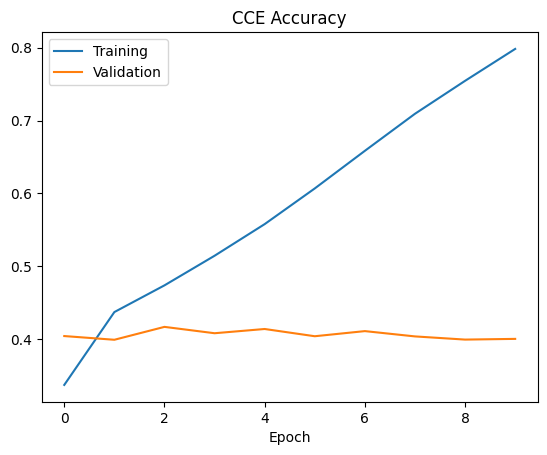

In [6]:
plt.plot(history.history["sparse_categorical_accuracy"])
plt.plot(history.history["val_sparse_categorical_accuracy"])
plt.legend(["Training", "Validation"])
plt.title("CCE Accuracy")
plt.xlabel("Epoch")
plt.show()